In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.sparse.linalg import arpack
from scipy.stats import pearsonr

from graspy.plot import heatmap
from graspy.utils import is_symmetric, symmetrize

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from simulations import rho_sbm_marg, rho_ER_marg, sbm_marg_corr_diff
from utils import sbm_params, triu_no_diag, to_distance_mtx, identity, permute_off_diag, permute_on_diag, block_permute, sort_graph

### rho-ER permutation

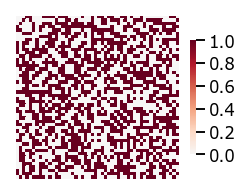

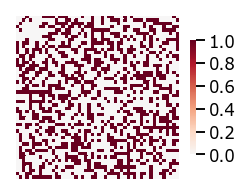

In [2]:
rho = 0.8
n = 50
A, B = rho_ER_marg(rho=rho, p=0.5, q=0.4, n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

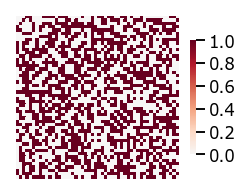

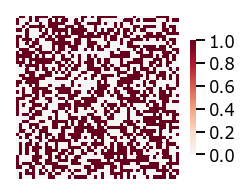

In [3]:
heatmap(A, figsize=(4,3))
heatmap(permute_on_diag(A), figsize=(4,3))

### rho-SBM permutation

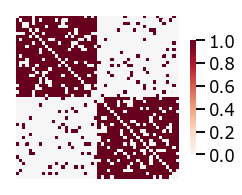

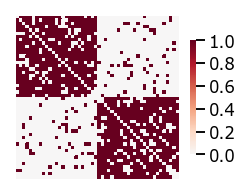

In [4]:
rho = 0.8
n = 50
k = 2
A, B = rho_sbm_marg(rho=rho, k=k, AL=sbm_params(a=0.8, b=0.1), BL=sbm_params(a=0.8, b=0.1), n=n)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

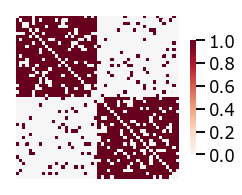

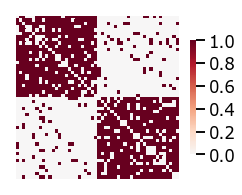

In [5]:
heatmap(A, figsize=(4,3))
heatmap(block_permute(A, np.repeat([0, 1], n//k)), figsize=(4,3))

In [6]:
is_symmetric(A)

True

In [7]:
is_symmetric(block_permute(A, np.repeat([0, 1], n//k)))

True

In [4]:
def rho_er_power(indept_test, transform_func, rho, p, q, n=50, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_ER_marg(rho, p, q, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        A_null = permute_on_diag(A)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [18]:
def rho_sbm_given_block_power(indept_test, transform_func, rho, P1, P2, k=2, n=50, mc=500, alpha=0.05):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = rho_sbm_marg(rho, k, P1, P2, n)
        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=transform_func(A), matrix_Y=transform_func(B))
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        block_assignment = np.repeat(np.arange(k), n//k)
        A_null = block_permute(A, block_assignment)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=transform_func(A_null), matrix_Y=transform_func(B))
        test_stat_null_array[i] = test_stat_null
    # if pearson, use the absolute value of test statistic then use one-sided
    # rejection region
    if indept_test.get_name() == 'pearson':
        test_stat_null_array = np.absolute(test_stat_null_array)
        test_stat_alt_array = np.absolute(test_stat_alt_array)
    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [10]:
n_arr = np.linspace(10, 100, 10, dtype=int)
nmc = 1000
rho_arr = np.array([0.1])
P = sbm_params(a=0.7, b=0.3)
test_names = ['pearson', 'dcorr', 'mgc']
power_sbm = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for i, rho in enumerate(rho_arr):
    for j, n in enumerate(n_arr):
        for name in test_names:
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_given_block_power(test, triu_no_diag, rho=rho, P1=P, P2=P, k=2, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P, P2=P, k=2, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P, P2=P, k=2, n=n, mc=nmc)
            power_sbm[name][i, j] = test_power
            print('finish {} for rho={}, n={}: power={}'.format(name, rho, n, test_power))

finish pearson for rho=0.1, n=10: power=0.114
finish dcorr for rho=0.1, n=10: power=0.125
finish mgc for rho=0.1, n=10: power=0.117
finish pearson for rho=0.1, n=20: power=0.317
finish dcorr for rho=0.1, n=20: power=0.287
finish mgc for rho=0.1, n=20: power=0.245
finish pearson for rho=0.1, n=30: power=0.459
finish dcorr for rho=0.1, n=30: power=0.518
finish mgc for rho=0.1, n=30: power=0.466
finish pearson for rho=0.1, n=40: power=0.757
finish dcorr for rho=0.1, n=40: power=0.727
finish mgc for rho=0.1, n=40: power=0.677
finish pearson for rho=0.1, n=50: power=0.915
finish dcorr for rho=0.1, n=50: power=0.866
finish mgc for rho=0.1, n=50: power=0.851
finish pearson for rho=0.1, n=60: power=0.983
finish dcorr for rho=0.1, n=60: power=0.975
finish mgc for rho=0.1, n=60: power=0.961
finish pearson for rho=0.1, n=70: power=0.995
finish dcorr for rho=0.1, n=70: power=0.991
finish mgc for rho=0.1, n=70: power=0.992
finish pearson for rho=0.1, n=80: power=1.0
finish dcorr for rho=0.1, n=80: 

In [11]:
power_sbm

{'pearson': array([[0.114, 0.317, 0.459, 0.757, 0.915, 0.983, 0.995, 1.   , 1.   ,
         1.   ]]),
 'dcorr': array([[0.125, 0.287, 0.518, 0.727, 0.866, 0.975, 0.991, 0.999, 1.   ,
         1.   ]]),
 'mgc': array([[0.117, 0.245, 0.466, 0.677, 0.851, 0.961, 0.992, 0.996, 1.   ,
         1.   ]])}

In [13]:
with open ('../../results/rho_sbm_power_alt.pkl', 'wb') as f:
    pickle.dump(power_sbm, f)

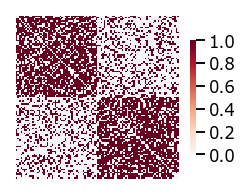

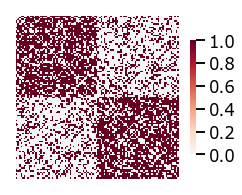

In [14]:
A, B = rho_sbm_marg(rho=0.0, k=2, AL=sbm_params(a=0.7, b=0.3), BL=sbm_params(a=0.7, b=0.3), n=100)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

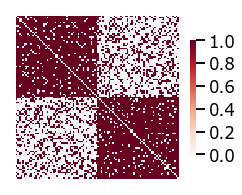

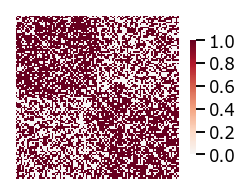

In [50]:
A, B = rho_sbm_marg(rho=0.1, k=2, AL=sbm_params(a=0.9, b=0.3), BL=sbm_params(a=0.7, b=0.5), n=100)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [192]:
rho=0.1
p=0.7
q=0.7
a = p*q + rho * np.sqrt(p*(1-p)*q*(1-q))
b = (1-p)*q - rho * np.sqrt(p*(1-p)*q*(1-q))
print('x=1, y=1: {}'.format(a))
print('x=1, y=0: {}'.format(p-a))
print('x=0, y=1: {}'.format(b))
print('x=0, y=0: {}'.format(1-p-b))

x=1, y=1: 0.5109999999999999
x=1, y=0: 0.18900000000000006
x=0, y=1: 0.189
x=0, y=0: 0.11100000000000004


In [193]:
rho=0.1
p=0.3
q=0.3
a = p*q + rho * np.sqrt(p*(1-p)*q*(1-q))
b = (1-p)*q - rho * np.sqrt(p*(1-p)*q*(1-q))
print('x=1, y=1: {}'.format(a))
print('x=1, y=0: {}'.format(p-a))
print('x=0, y=1: {}'.format(b))
print('x=0, y=0: {}'.format(1-p-b))

x=1, y=1: 0.111
x=1, y=0: 0.189
x=0, y=1: 0.189
x=0, y=0: 0.5109999999999999


In [89]:
n = 100
rho = 0.1
P1 = sbm_params(a=0.7, b=0.3)
a_arr = np.linspace(0.1, 0.9, 9)
b_arr = np.linspace(0.1, 0.9, 9)
power = np.full((9, 9), -1, dtype=float)
for i, a in enumerate(a_arr):
    for j, b in enumerate(b_arr):
        P2 = sbm_params(a=a, b=b)
        test = RVCorr(which_test='pearson')
        try:
            test_power = rho_sbm_given_block_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=2, n=n, mc=500)
        except ValueError:
            continue
        power[i, j] = test_power

In [168]:
def isPSD(A, tol = 1e-8):
    vals, vecs = arpack.eigsh(A, k = 2, which = 'BE') # return the ends of spectrum of A
    return np.all(vals > -tol)

In [185]:
a_arr = np.linspace(0.1, 0.9, 9)
b_arr = np.linspace(0.1, 0.9, 9)
psd1 = np.full((9, 9), -1)
for i, a in enumerate(a_arr):
    for j, b in enumerate(b_arr):
        P2 = sbm_params(a=a, b=b)
        psd1[i, j] = isPSD(P2)

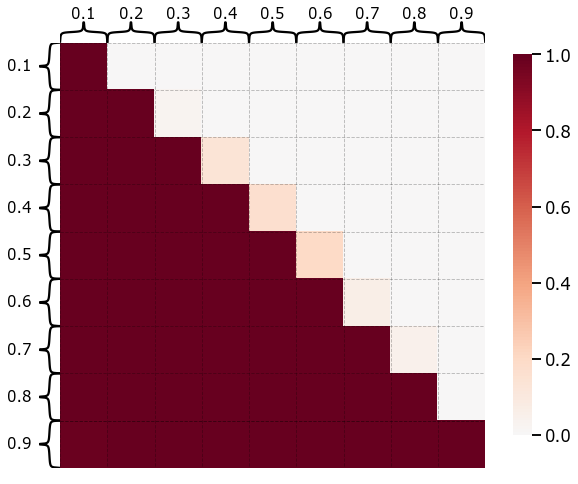

In [187]:
heatmap(power, inner_hier_labels=np.around(a_arr, decimals=1))

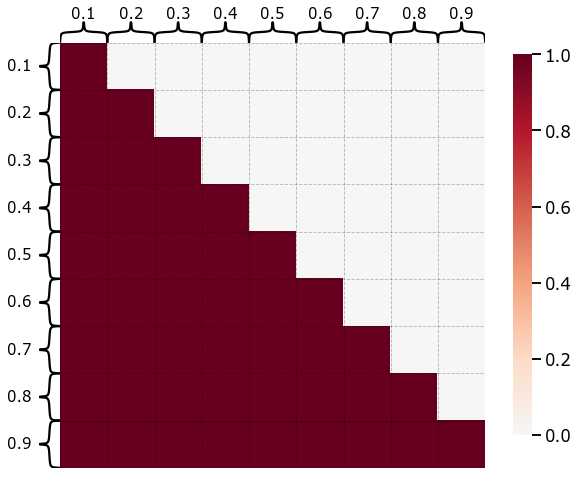

In [188]:
heatmap(psd1, inner_hier_labels=np.around(a_arr, decimals=1))

In [91]:
n = 100
rho = 0.1
P1 = sbm_params(a=0.3, b=0.7)
a_arr = np.linspace(0.1, 0.9, 9)
b_arr = np.linspace(0.1, 0.9, 9)
power2 = np.full((9, 9), -1, dtype=float)
for i, a in enumerate(a_arr):
    for j, b in enumerate(b_arr):
        P2 = sbm_params(a=a, b=b)
        test = RVCorr(which_test='pearson')
        try:
            test_power = rho_sbm_given_block_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=2, n=n, mc=500)
        except ValueError:
            continue
        power2[i, j] = test_power

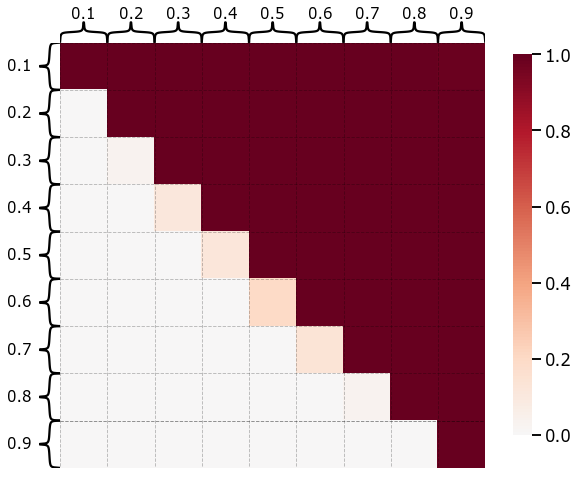

In [189]:
heatmap(power2, inner_hier_labels=np.around(a_arr, decimals=1))

In [169]:
a = np.array([[0.5, 0.2, 0.4], [0.2, 0.5, 0.2], [0.4, 0.2, 0.5]])

In [143]:
n = 100
rho = 0.1
P1 = np.array([[0.5, 0.2, 0.4], [0.2, 0.5, 0.2], [0.4, 0.2, 0.5]])
a_arr = np.linspace(0.1, 0.9, 9)
b_arr = np.linspace(0.1, 0.9, 9)
c_arr = np.linspace(0.1, 0.9, 9)
power3 = np.full((9, 9, 9), -1, dtype=float)
for i, a in enumerate(a_arr):
    for j, b in enumerate(b_arr):
        for k, c in enumerate(c_arr):
            P2 = np.array([[a, b, c], [b, a, b], [c, b, a]])
            test = RVCorr(which_test='pearson')
            try:
                test_power = rho_sbm_given_block_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=3, n=n, mc=500)
            except ValueError:
                continue
            power3[i, j, k] = test_power

In [199]:
a_arr = np.around(np.linspace(0.1, 0.9, 9), decimals=1)
b_arr = np.around(np.linspace(0.1, 0.9, 9), decimals=1)
c_arr = np.around(np.linspace(0.1, 0.9, 9), decimals=1)
psd3 = np.full((9, 9, 9), -1)
for i, a in enumerate(a_arr):
    for j, b in enumerate(b_arr):
        for k, c in enumerate(c_arr):
            P2 = np.array([[a, b, c], [b, a, b], [c, b, a]])
            psd3[i, j, k] = isPSD(P2)

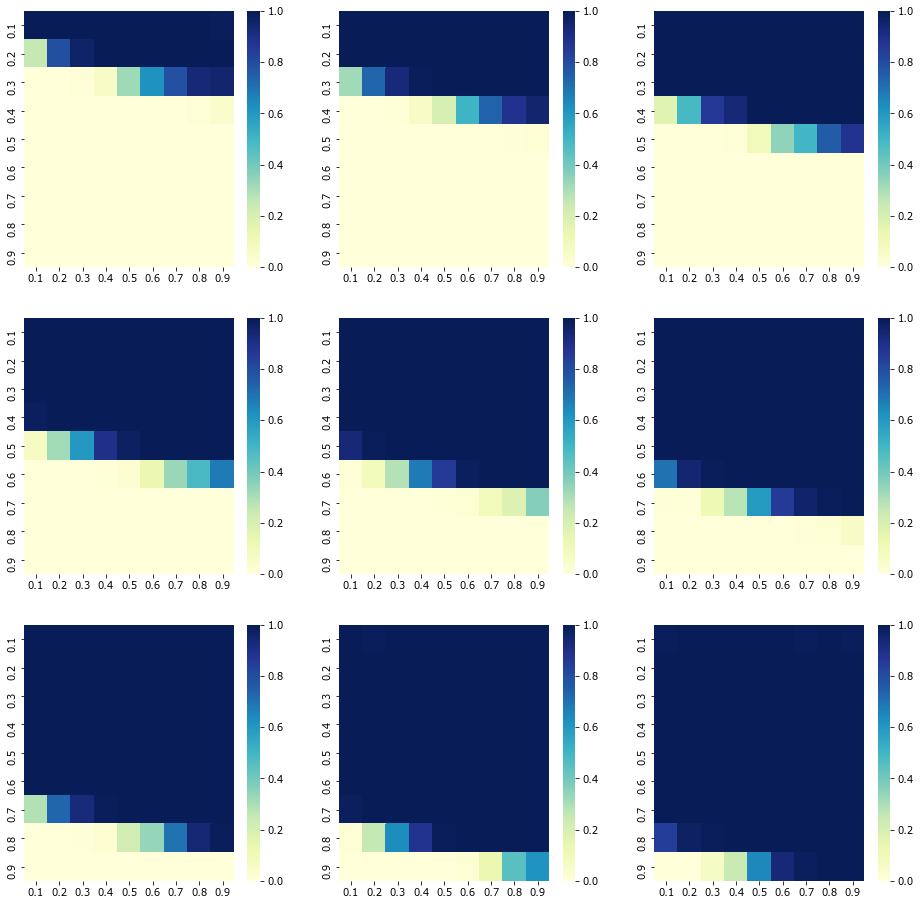

In [209]:
fig = plt.figure(figsize=(16, 16))
for i, a in enumerate(a_arr):
    fig.add_subplot(3, 3, i+1)
    sns.heatmap(power3[i, :, :], cmap="YlGnBu", xticklabels=a_arr, yticklabels=a_arr)
plt.savefig('../../figures/pearson_power.png', bbox_inches='tight')

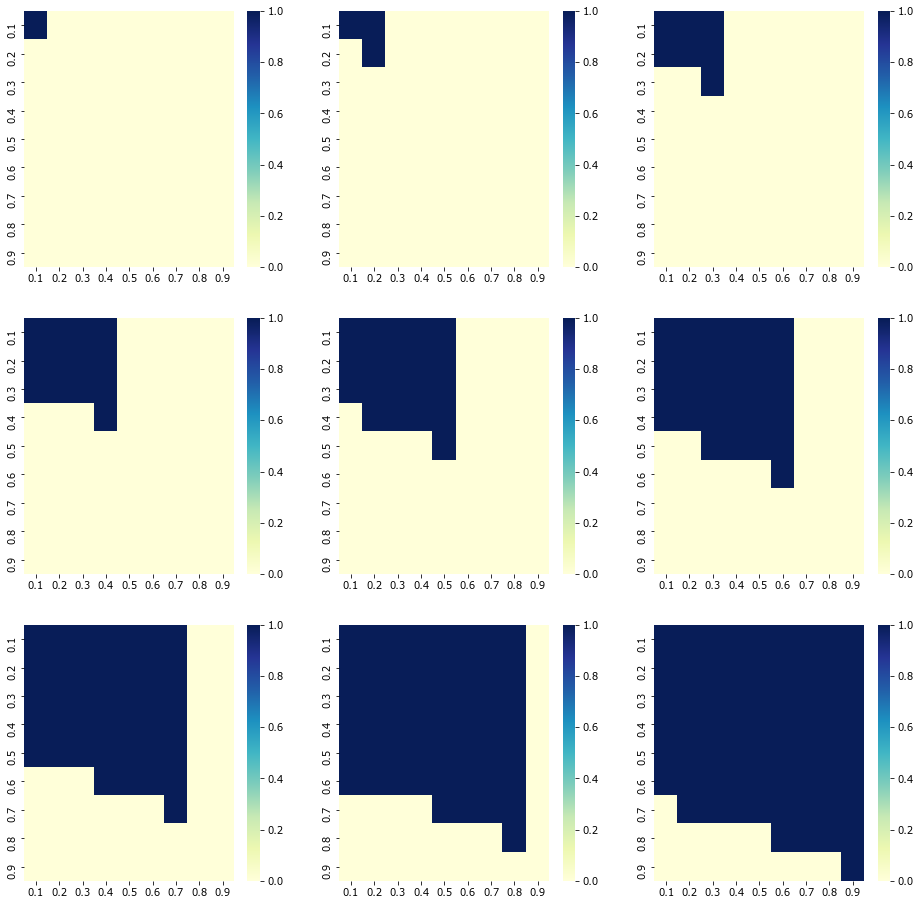

In [210]:
fig = plt.figure(figsize=(16, 16))
for i, a in enumerate(a_arr):
    fig.add_subplot(3, 3, i+1)
    sns.heatmap(psd3[i, :, :], cmap="YlGnBu", xticklabels=a_arr, yticklabels=a_arr)
plt.savefig('../../figures/pearson_psd.png', bbox_inches='tight')

In [145]:
def set_P():
    P1 = np.array([[0.5, 0.2, 0.4], [0.2, 0.5, 0.2], [0.4, 0.2, 0.5]])
    P2 = np.array([[0.5, 0.2, 0.1], [0.2, 0.5, 0.2], [0.1, 0.2, 0.5]])
    return P1, P2

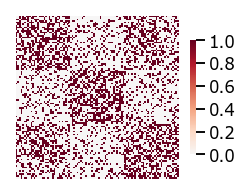

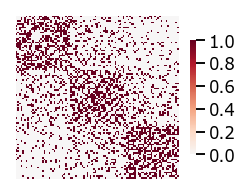

In [211]:
P1, P2 = set_P()
A, B = rho_sbm_marg(rho=0.1, k=3, AL=P1, BL=P2, n=100)
heatmap(A, figsize=(4,3))
heatmap(B, figsize=(4,3))

In [147]:
n_arr = np.array([100]) #np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0.1])
k = 3
P1, P2 = set_P()
nmc = 500
test_names = ['pearson']
power_sbm_marg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_sbm_given_block_power(test, triu_no_diag, rho=rho, P1=P1, P2=P2, k=k, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_sbm_given_block_power(test, to_distance_mtx, rho=rho, P1=P1, P2=P2, k=k, n=n, mc=nmc)
            power_sbm_marg[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.1, n=100


In [148]:
power_sbm_marg

{'pearson': array([[1.]]), 'dcorr': array([[0.]]), 'mgc': array([[0.]])}

In [18]:
with open ('../../results/rho_sbm_marg_power_alt_v1.pkl', 'wb') as f:
    pickle.dump(power_sbm_marg, f)

In [ ]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0.1])
nmc = 1000
test_names = ['pearson', 'dcorr', 'mgc']
power_rho_er = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_er_power(test, triu_no_diag, rho=rho, p=0.5, q=0.5, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.5, q=0.5, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.5, q=0.5, n=n, mc=nmc)
            power_rho_er[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

In [20]:
power_rho_er

{'pearson': array([[0.076, 0.218, 0.548, 0.796, 0.954, 0.987, 0.999, 0.999, 1.   ,
         1.   ]]),
 'dcorr': array([[0.122, 0.329, 0.668, 0.882, 0.96 , 0.994, 1.   , 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.147, 0.387, 0.623, 0.86 , 0.957, 0.993, 1.   , 1.   , 1.   ,
         1.   ]])}

In [21]:
with open ('../../results/rho_er_power_alt.pkl', 'wb') as f:
    pickle.dump(power_rho_er, f)

In [23]:
n_arr = np.linspace(10, 100, 10, dtype=int)
rho_arr = np.array([0, 0.1])
nmc = 1000
test_names = ['pearson', 'dcorr', 'mgc']
power_rho_er_marg = {
    'pearson': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'dcorr': np.zeros((rho_arr.shape[0], n_arr.shape[0])),
    'mgc': np.zeros((rho_arr.shape[0], n_arr.shape[0]))
}

for name in test_names:
    for i, rho in enumerate(rho_arr):
        for j, n in enumerate(n_arr):
            if name == 'pearson':
                test = RVCorr(which_test='pearson')
                test_power = rho_er_power(test, triu_no_diag, rho=rho, p=0.7, q=0.2, n=n, mc=nmc)
            elif name == 'dcorr':
                test = DCorr(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.7, q=0.2, n=n, mc=nmc)
            elif name == 'mgc':
                test = MGC(compute_distance_matrix=identity)
                test_power = rho_er_power(test, to_distance_mtx, rho=rho, p=0.7, q=0.2, n=n, mc=nmc)
            power_rho_er_marg[name][i, j] = test_power
            print('finish {} for rho={}, n={}'.format(name, rho, n))

finish pearson for rho=0.0, n=10
finish pearson for rho=0.0, n=20
finish pearson for rho=0.0, n=30
finish pearson for rho=0.0, n=40
finish pearson for rho=0.0, n=50
finish pearson for rho=0.0, n=60
finish pearson for rho=0.0, n=70
finish pearson for rho=0.0, n=80
finish pearson for rho=0.0, n=90
finish pearson for rho=0.0, n=100
finish pearson for rho=0.1, n=10
finish pearson for rho=0.1, n=20
finish pearson for rho=0.1, n=30
finish pearson for rho=0.1, n=40
finish pearson for rho=0.1, n=50
finish pearson for rho=0.1, n=60
finish pearson for rho=0.1, n=70
finish pearson for rho=0.1, n=80
finish pearson for rho=0.1, n=90
finish pearson for rho=0.1, n=100


/Users/jxiong/Documents/Projects/graph_independence_test/utils.py:161: RuntimeWarning: invalid value encountered in true_divide
  distance_mtx_A = 1 - (A / np.max(A))
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


finish dcorr for rho=0.0, n=10
finish dcorr for rho=0.0, n=20
finish dcorr for rho=0.0, n=30
finish dcorr for rho=0.0, n=40
finish dcorr for rho=0.0, n=50
finish dcorr for rho=0.0, n=60
finish dcorr for rho=0.0, n=70
finish dcorr for rho=0.0, n=80
finish dcorr for rho=0.0, n=90
finish dcorr for rho=0.0, n=100
finish dcorr for rho=0.1, n=10
finish dcorr for rho=0.1, n=20
finish dcorr for rho=0.1, n=30
finish dcorr for rho=0.1, n=40
finish dcorr for rho=0.1, n=50
finish dcorr for rho=0.1, n=60
finish dcorr for rho=0.1, n=70
finish dcorr for rho=0.1, n=80
finish dcorr for rho=0.1, n=90
finish dcorr for rho=0.1, n=100
finish mgc for rho=0.0, n=10
finish mgc for rho=0.0, n=20
finish mgc for rho=0.0, n=30
finish mgc for rho=0.0, n=40
finish mgc for rho=0.0, n=50
finish mgc for rho=0.0, n=60
finish mgc for rho=0.0, n=70
finish mgc for rho=0.0, n=80
finish mgc for rho=0.0, n=90
finish mgc for rho=0.0, n=100
finish mgc for rho=0.1, n=10
finish mgc for rho=0.1, n=20
finish mgc for rho=0.1, n=30


In [24]:
power_rho_er_marg

{'pearson': array([[0.05 , 0.041, 0.066, 0.035, 0.052, 0.055, 0.036, 0.044, 0.07 ,
         0.059],
        [0.074, 0.224, 0.555, 0.823, 0.956, 0.994, 1.   , 0.999, 1.   ,
         1.   ]]),
 'dcorr': array([[0.045, 0.066, 0.071, 0.052, 0.055, 0.05 , 0.038, 0.055, 0.037,
         0.058],
        [0.161, 0.376, 0.634, 0.887, 0.963, 0.994, 1.   , 1.   , 1.   ,
         1.   ]]),
 'mgc': array([[0.047, 0.041, 0.06 , 0.058, 0.044, 0.052, 0.059, 0.066, 0.06 ,
         0.045],
        [0.15 , 0.415, 0.638, 0.858, 0.978, 0.997, 1.   , 1.   , 1.   ,
         1.   ]])}

In [26]:
with open ('../../results/rho_er_marg_power.pkl', 'wb') as f:
    pickle.dump(power_rho_er_marg, f)

In [3]:
n = 100
A, B = rho_ER_marg(rho=0.1, p=0.5, q=0.5, n=n)
blocks = np.repeat(np.arange(1), n//1)
B_sorted = sort_graph(B, blocks)

In [7]:
np.all(B == B_sorted)

True